# Time-series Forecasting

## Imports

In [83]:
import os

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Optional
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
packetLossRate = np.random.random((100,))
jitter = np.arange(100)
latency = np.random.random((100,))

In [204]:
from datetime import datetime, timedelta

current = datetime.now()
times = [(current + timedelta(seconds=(i + i % 60 / 60))).strftime("%Y-%m-%d %H:%M:%S.%f") for i in range(100)]

In [208]:
df = pd.DataFrame({
    'packetLossRate': packetLossRate,
    'jitter': jitter,
    'latency': latency,
    'timestamp': times
})
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [209]:
df

,packetLossRate,jitter,latency,timestamp
0,0.668446,0,0.828346,2022-03-23 23:36:16.614210
1,0.014893,1,0.052994,2022-03-23 23:36:17.630877
2,0.557655,2,0.350046,2022-03-23 23:36:18.647543
3,0.186798,3,0.678243,2022-03-23 23:36:19.664210
4,0.528714,4,0.167260,2022-03-23 23:36:20.680877
...,...,...,...,...
95,0.182560,95,0.718027,2022-03-23 23:37:52.197543
96,0.456564,96,0.726335,2022-03-23 23:37:53.214210
97,0.898017,97,0.950072,2022-03-23 23:37:54.230877
98,0.939016,98,0.853480,2022-03-23 23:37:55.247543


In [221]:
class WindowGenerator():

    def __init__(self,
                 input_width: int, label_width: int, offset: int,
                 train_df, val_df, test_df,
                 input_columns:Optional[List[str]]=None, label_columns:Optional[List[str]]=None,
                 timestamp_column:str='timestamp'):
        """Create a new instance of WindowGenerator class

        Args:
            input_width (int): Length of input sequence.
            label_width (int): Length of output sequence.
            offset (int): Offset between input and output.
            train_df (DataFrame): The data for training.
            val_df (DataFrame): The data for validation.
            test_df (DataFrame): The data for testing.
            input_columns (Optional[List[str]], optional): Input column names. Defaults to None.
            label_columns (Optional[List[str]], optional): Output column names. Defaults to None.
            timestamp_column (str, optional): Name of the timestamp column. Defaults to 'timestamp'.
        """
        
        self.train_time = train_df.pop(timestamp_column)
        self.val_time = val_df.pop(timestamp_column)
        self.test_time = test_df.pop(timestamp_column)
        
        self.train_mean = train_df.mean()
        self.train_std = train_df.std()

        train_df = (train_df - self.train_mean) / self.train_std
        val_df = (val_df - self.train_mean) / self.train_std
        test_df = (test_df - self.train_mean) / self.train_std

        # Store the raw data
        self.train_df = train_df
        self.train_index = np.arange(len(train_df)).reshape(-1, 1)
        self.val_df = val_df
        self.val_index = np.arange(len(val_df)).reshape(-1, 1)
        self.test_df = test_df
        self.test_index = np.arange(len(test_df)).reshape(-1, 1)

        # Work out the label column indices.
        self.input_columns = input_columns
        self.label_columns = label_columns
        self.timestamp_column = timestamp_column
        if input_columns is not None:
            self.input_columns_indices = {name: i for i, name in enumerate(input_columns)}
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.columns = train_df.columns
        self.column_indices = {name: i for i, name in enumerate(self.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.offset = offset

        self.total_window_size = input_width + offset

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_window(self, features):
        indices = tf.expand_dims(features[:, :, -1], -1)
        features = features[:, :, :-1]
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        
        if self.input_columns is not None:
            inputs = tf.stack(
                [inputs[:, :, self.column_indices[name]] for name in self.input_columns],
                axis=-1
            )
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, len(self.input_columns if self.input_columns else self.columns)])
        labels.set_shape([None, self.label_width, len(self.label_columns if self.label_columns else self.columns)])
        indices.set_shape([None, self.total_window_size, 1])

        return inputs, indices, labels
    
    def make_dataset(self, data, indices, batch, shuffle=True):
        data = np.array(data, dtype=np.float32)
        data = np.hstack([data, indices])

        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=shuffle,
            batch_size=batch
        )

        ds = ds.map(self.split_window)

        return ds

    def train(self, batch=32):
        return self.make_dataset(self.train_df, self.train_index, batch)

    def val(self, batch=32):
        return self.make_dataset(self.val_df, self.val_index, batch)

    def test(self, batch=32):
        return self.make_dataset(self.test_df, self.test_index, batch, False)

    def plot(self, model, plot_col='packetLossRate', max_subplots=3):
        inputs, indices, labels = next(iter(self.test().take(1)))
        indices = tf.squeeze(indices, axis=-1)
        
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        input_col_index = self.input_columns_indices.get(plot_col, None) if self.input_columns else plot_col_index
        assert input_col_index is not None
        max_n = min(max_subplots, len(inputs))

        name = None
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(plot_col)
            sub_indices = indices[n, ::5]
            if n == 0:
                name = self.test_time[sub_indices][0].strftime("%Y-%m-%d %H:%M")
            sub_times = [x.strftime("%S") for x in self.test_time[sub_indices]]
            sub_ticks = np.arange(self.total_window_size)[::5]
            plt.xticks(sub_ticks, sub_times)
            values = inputs[n, :, input_col_index] * self.train_std[plot_col] + self.train_mean[plot_col]
            plt.plot(self.input_indices, values,
                    label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            values = labels[n, :, label_col_index] * self.train_std[plot_col] + self.train_mean[plot_col]
            plt.scatter(self.label_indices, values,
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                values = predictions[n, :, label_col_index] * self.train_std[plot_col] + self.train_mean[plot_col]
                plt.scatter(self.label_indices, values,
                            marker='X', edgecolors='k', label='Predictions',
                            c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time ' + name + ' [s]')

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Input column name(s): {self.input_columns if self.input_columns else self.columns}',
            f'Label column name(s): {self.label_columns if self.label_columns else self.columns}'
        ])


In [222]:
s1 = WindowGenerator(20, 5, 10, train_df=df.copy(), val_df=df.copy(), test_df=df.copy(), label_columns=['packetLossRate', 'jitter'])
s1

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Label indices: [25 26 27 28 29]
Input column name(s): Index(['packetLossRate', 'jitter', 'latency'], dtype='object')
Label column name(s): ['packetLossRate', 'jitter']

In [171]:
for inputs, indices, outputs in s1.test().take(2):
    print(inputs.shape, indices.shape, outputs.shape)

(32, 20, 3) (32, 5, 1) (32, 5, 2)
(32, 20, 3) (32, 5, 1) (32, 5, 2)


In [223]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((20, 3)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(2),
    tf.keras.layers.Cropping1D(cropping=(15, 0))
])
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 20, 128)           67584     
                                                                 
 dense_15 (Dense)            (None, 20, 2)             258       
                                                                 
 cropping1d_7 (Cropping1D)   (None, 5, 2)              0         
                                                                 
Total params: 67,842
Trainable params: 67,842
Non-trainable params: 0
_________________________________________________________________


In [224]:
model.compile(loss='mse', optimizer='adam')

In [225]:
train_data = s1.train().map(lambda x,y,z: (x, z))
train_data

<MapDataset element_spec=(TensorSpec(shape=(None, 20, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5, 2), dtype=tf.float64, name=None))>

In [226]:
model.fit(train_data, epochs=20)

Epoch 1/20
3/3 [==============================] - 2s 14ms/step - loss: 0.7799
Epoch 2/20
3/3 [==============================] - 0s 11ms/step - loss: 0.6457
Epoch 3/20
3/3 [==============================] - 0s 10ms/step - loss: 0.5608
Epoch 4/20
3/3 [==============================] - 0s 9ms/step - loss: 0.5362
Epoch 5/20
3/3 [==============================] - 0s 9ms/step - loss: 0.5129
Epoch 6/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4916
Epoch 7/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4915
Epoch 8/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4884
Epoch 9/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4852
Epoch 10/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4865
Epoch 11/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4829
Epoch 12/20
3/3 [==============================] - 0s 9ms/step - loss: 0.4794
Epoch 13/20
3/3 [==============================] - 0s 9ms/step - loss:

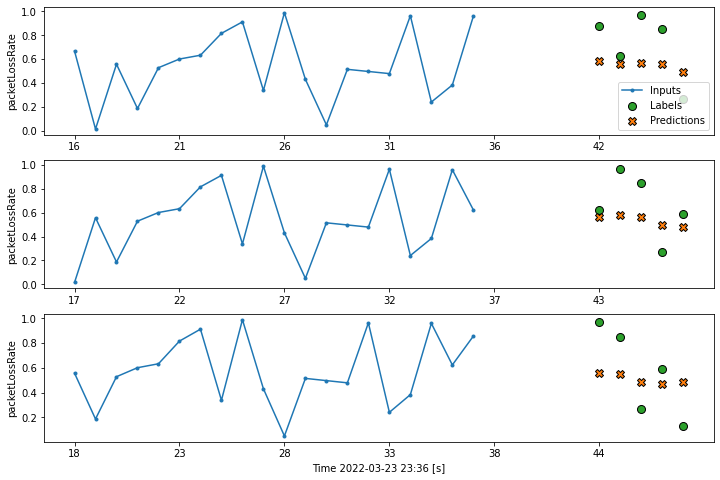

In [227]:
s1.plot(model)